<a href="https://colab.research.google.com/github/OH1107/Project/blob/master/Analyze_Stock_as_NaverDataLab/Analyze_Stock_as_NaverDataLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')
fm._rebuild()

mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
import requests
from bs4 import BeautifulSoup as bs
from pandas.io import gbq

## 크롤링 및 데이터 로드

In [ ]:
def one_page_crawling(code,page):
  url='https://finance.naver.com/item/sise_day.nhn?code={code}&page={page}'.format(code=code,page=page)
  df = pd.read_html(url)[0]
  df.dropna(inplace=True)
  df['날짜'] = df['날짜'].apply(lambda x : str(x).replace('.',''))
  df['날짜'] = df['날짜'].astype('int')
  df.columns = ['SDAY','CLOSEP','SCOMP','OPENP','HIGHP','LOWP','VOL']
  return df

In [ ]:
def several_page_crawling(code,page):
  url='https://finance.naver.com/item/sise_day.nhn?code={code}&page={page}'.format(code=code,page=page)
  df = pd.DataFrame()
  for i in range(1,page+1):
    new_df = one_page_crawling(code,i)
    df = pd.concat([df,new_df], axis=0)
  df.dropna(inplace=True)
  df.reset_index(inplace=True, drop=True)
  return df

In [ ]:
def save_to_query(df, Data_set='', data_table=''):
  df.to_gbq(destination_table=Data_set+'.'+data_table, 
                  project_id='groovy-ego-286903',
                  if_exists='replace')

In [ ]:
df=several_page_crawling('097950',321)


In [ ]:
save_to_query(df,'Stock_data','cj_stock')

1it [00:04,  4.12s/it]


In [ ]:
enm_df=several_page_crawling('035760',511)

In [ ]:
save_to_query(enm_df, 'Stock_data','cj_enm_stock')

1it [00:03,  3.63s/it]


In [ ]:
project_id = 'groovy-ego-286903'
sql = """
    SELECT SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL
    FROM `Stock_data.cj_enm_stock`
    WHERE SDAY >= 20190101 AND SDAY <= 20200830
    ORDER BY SDAY desc
    """
cj_enm_df = pd.read_gbq(sql, project_id=project_id, dialect='standard')
cj_enm_df.head()

,SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL
0,20200828,120300.0,118100.0,121400.0,117500.0,114817.0
1,20200827,121900.0,118000.0,121900.0,118000.0,142667.0
2,20200826,122300.0,121600.0,124200.0,120200.0,110258.0
3,20200825,120600.0,124400.0,125300.0,120300.0,95457.0
4,20200824,119500.0,120000.0,120000.0,115700.0,106881.0


## 네이버 데이터 랩

In [ ]:
from pandas.io import gbq

import os
import sys
import urllib.request
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')
fm._rebuild()

mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
def makeQry(keywords=[],sdate='',edate='',tunit='date'):
  res = []
  for word in keywords:
    dict={'groupName':word[0], 'keywords':word}
    res.append(dict)
  

  rdict={"startDate":sdate,
         "endDate":edate,
         "timeUnit":tunit,
         "keywordGroups":res}
  return json.dumps(rdict, ensure_ascii=False)

In [ ]:
def Mynsearch(keywords=[],sdate='',edate='',tunit='date'):
  client_id = "GjOIh9f0eos4ZlO0MuPJ"
  client_secret = "6D0DNFKlWz"
  url = "https://openapi.naver.com/v1/datalab/search";
 
  body = makeQry(keywords, sdate, edate, tunit)

  request = urllib.request.Request(url)
  request.add_header("X-Naver-Client-Id",client_id)
  request.add_header("X-Naver-Client-Secret",client_secret)
  request.add_header("Content-Type","application/json")
  response = urllib.request.urlopen(request, data=body.encode("utf-8"))
  rescode = response.getcode()
  if (rescode==200):
    response_body = response.read()
    res=response_body.decode('utf-8')
    #print(res)
  else:
    res='error'
    print("Error Code:" + rescode)
  return res

In [ ]:
def MyDataLab(keywords=[],sdate='',edate='',tunit='date'):
  # 네이버 데이터랩 서치
  res=Mynsearch(keywords, sdate, edate, tunit)

  # 데이터 추출을 위한 json
  jdata=json.loads(res)

  # 테이블 머지를 위한 기초테이블
  maindf=pd.DataFrame()

  # 키워드별로 컬럼명 지정
  i =0
  for words in keywords:
    pdata=jdata['results'][i]['data']
    i += 1
    df=pd.DataFrame.from_dict(pdata)
    df.columns=["period",words[0]]
    df.set_index("period", inplace=True)
    maindf=pd.merge(maindf, df, how='outer', left_index=True, right_index=True)

  return maindf

In [ ]:
def MyDBLab(keywords=[], sdate='', edate='', tunit='date', Stock_data_location=''):
  # 데이터랩 사용자 정의 함수
  mdf=MyDataLab(keywords, sdate ,edate, tunit)
  
  # 쿼리문에 대입하기 위한 변수 선언
  sdaycode=sdate.replace('-','')
  edaycode=edate.replace('-','')
  
  # BigQuery로 부터 Stock데이터 호출
  project_id = 'groovy-ego-286903'
  sql = "SELECT SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL FROM "+Stock_data_location+" WHERE SDAY >="+sdaycode+" and SDAY<="+edaycode+" ORDER BY SDAY asc"
  
  company_df = pd.read_gbq(sql, project_id=project_id, dialect='standard')

  # Stock데이터와 데이터랩 데이터를 merge시키기 위한 index작업
  company_df['period']=[str(i)[:4]+'-'+str(i)[4:-2]+'-'+str(i)[-2:] for i in company_df['SDAY']]
  df_stock=company_df.set_index('period')
  
  # 그래프를 호출하기 위해 all_df로 merge
  df=pd.merge(df_stock, mdf, how='outer', left_index=True, right_index=True)

  # 선형보간
  all_df=df.interpolate() 

  return all_df

In [ ]:
def pltDBLab(all_df, keywords, xstep=30, ptitle='CJ ENM 영화와 주가의 상관도'):
  xtic=np.arange(0, len(all_df.index), step=xstep)
  xdays=[all_df.index[i] for i in xtic]

  set_df=pd.DataFrame()
  for words in keywords:
    set_df=pd.concat((set_df, all_df[words]), axis=1)


  # X 축을 공유하고 Y 축을 이중으로 사용
  plt.rcParams["figure.figsize"] = (16,8)

  fig, ax1= plt.subplots()

  # 주가 그래프
  ax1.plot(all_df['CLOSEP'], c='k')

  """
  # 영화 개봉일을 수직선으로 표현 
  movie_release_date = {'극한직업':['2019-01-23','blue'],
                      '사바하':['2019-02-20','orange'],
                      '걸캅스':['2019-05-09','green'],
                      '나쁜녀석들':['2019-09-11','purple'],
                      '백두산':['2019-12-19','red']}
  
  global location_num
  location_num = 0
  
  for movie, date_color in movie_release_date.items():
    # 수직선 출력
    ax1.axvline(x=date_color[0], label=movie, color=date_color[1], linestyle='--', linewidth=2)

    # 수직선 옆 text 출력
    idx=list(all_df.index)
    temp=location_num
    location_num=idx.index(date_color[0])
    if (temp != 0 and location_num-temp < 30):
      plt.text(location_num+2,245000, "{} 개봉".format(movie))
    else:
      plt.text(location_num+2,240000, "{} 개봉".format(movie))
  """

  ax1.set_ylabel('Price')
  plt.xticks(xtic, xdays, rotation=45)

  # 네이버 데이터 랩 영화 검색량 그래프
  ax2=ax1.twinx()
  ax2.set_ylabel("Ratio")

  # 그래프 출력, 조정
  set_df.plot(ax=ax2)

  plt.title(ptitle, fontdict={'fontsize':20})
  plt.legend()
  plt.tight_layout()
  plt.show()

In [ ]:
keywords=[['극한직업'],['사바하'],['걸캅스'],['나쁜녀석들'],['백두산']]

In [ ]:
df=MyDBLab(keywords, '2019-01-01', '2020-08-30', 'date', 'Stock_data.cj_enm_stock')

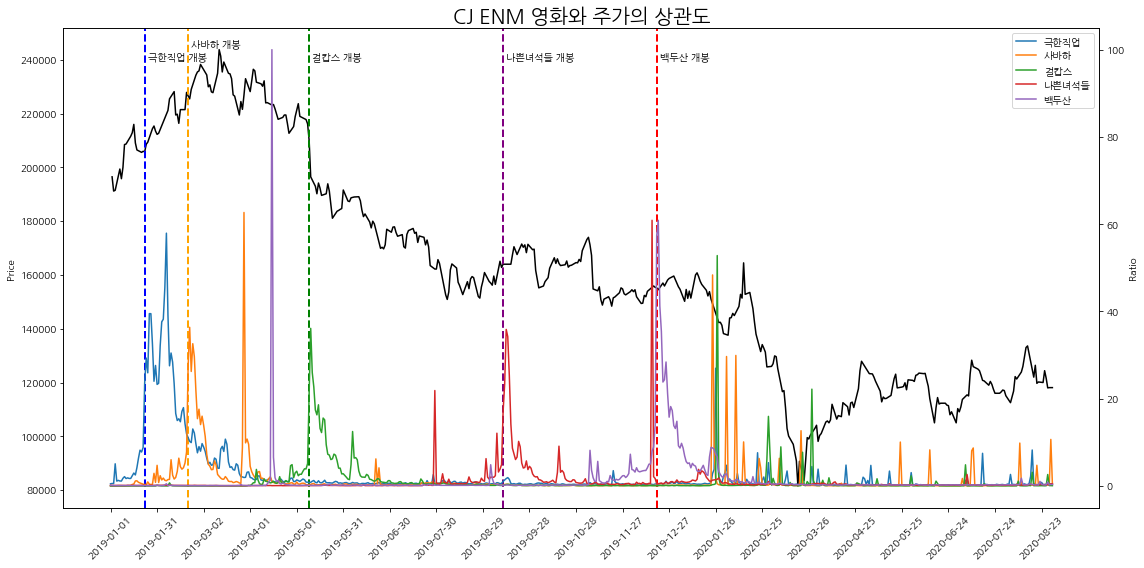

In [ ]:
pltDBLab(df, keywords, 30, 'CJ ENM 영화와 주가의 상관도')

## 주가와 데이터랩검색량 상관관계 분석

In [ ]:
def shiftGraph(shift_all, baseCol ,ptitle='shift 결과',xstep=10, shiftday=10):

    xtic=np.arange(0,len(shift_all.index),step=10)
    xdays=[shift_all.index[i] for i in xtic]

    col_name = baseCol + '_shift'
    sdf=shift_all[col_name]#,'사바하','걸캅스','나쁜녀석들','백두산'
    
    plt.rcParams["figure.figsize"]=(12,6)
    
    fig, ax1=plt.subplots()

    plt.xticks(xtic,xdays,rotation=45)
    
    ax1.plot(shift_all['CLOSEP'] ,color='black')
    ax1.set_ylabel("Price")
    ax2=ax1.twinx()
    ax2.set_ylabel("Ratio")
    
    sdf.plot(ax=ax2)
    
    plt.title(ptitle)
    plt.legend()
    fig.tight_layout()
    plt.show()

In [ ]:
def shiftLab(all_df , baseCol='극한직업', shiftday=5):

  # 기존 정보상의 상관분석 (효과가 적음)
  check_df=all_df[['CLOSEP',baseCol]]
  print("*"*40)
  print(check_df.describe())
  print("*"*40)
  print(check_df.corr())

  # 쉬프트 정보 작성
  check_df.columns=['CLOSEP', baseCol+'_shift']
  shift_df=check_df[''+baseCol+'_shift'].shift(shiftday, fill_value=0)

  # 기존 데이터와 병합
  shift_all = pd.merge(all_df, shift_df, how='inner', left_index=True, right_index=True)
  check5=shift_all[['CLOSEP',baseCol+'_shift']]

  # 새로운 상관분석
  print("*"*40)
  print(check5.corr())
  print("*"*40)
  
  shiftGraph(shift_all, baseCol)

### 극한직업

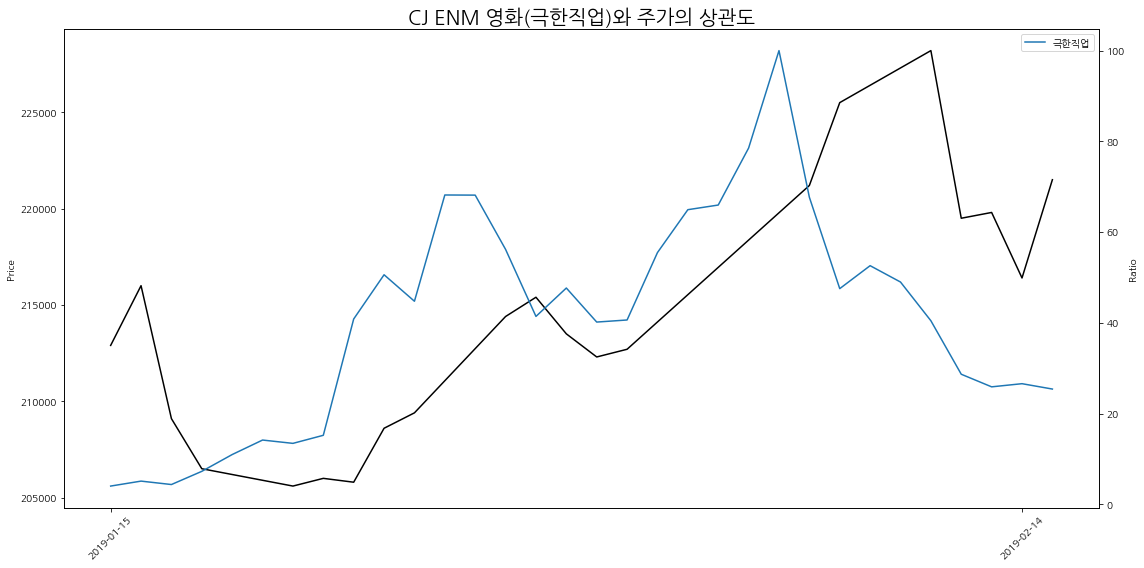

In [ ]:
keywords = [['극한직업']]
movie1_df=MyDBLab(keywords, '2019-01-15', '2019-02-15', 'date', 'Stock_data.cj_enm_stock')
pltDBLab(movie1_df, keywords, 30, 'CJ ENM 영화(극한직업)와 주가의 상관도')

****************************************
              CLOSEP        극한직업
count      32.000000   32.000000
mean   214832.812500   40.700198
std      6635.355887   24.167937
min    205600.000000    4.049350
25%    209325.000000   22.878787
50%    214258.333333   41.146570
75%    219570.833333   55.676147
max    228200.000000  100.000000
****************************************
          CLOSEP      극한직업
CLOSEP  1.000000  0.390641
극한직업    0.390641  1.000000
****************************************
             CLOSEP  극한직업_shift
CLOSEP      1.00000     0.81211
극한직업_shift  0.81211     1.00000
****************************************


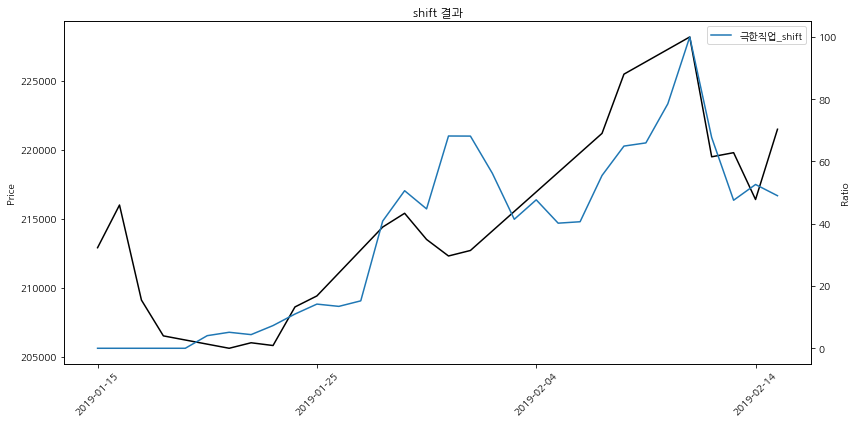

In [ ]:
shiftLab(movie1_df, '극한직업', 5)

### 사바하

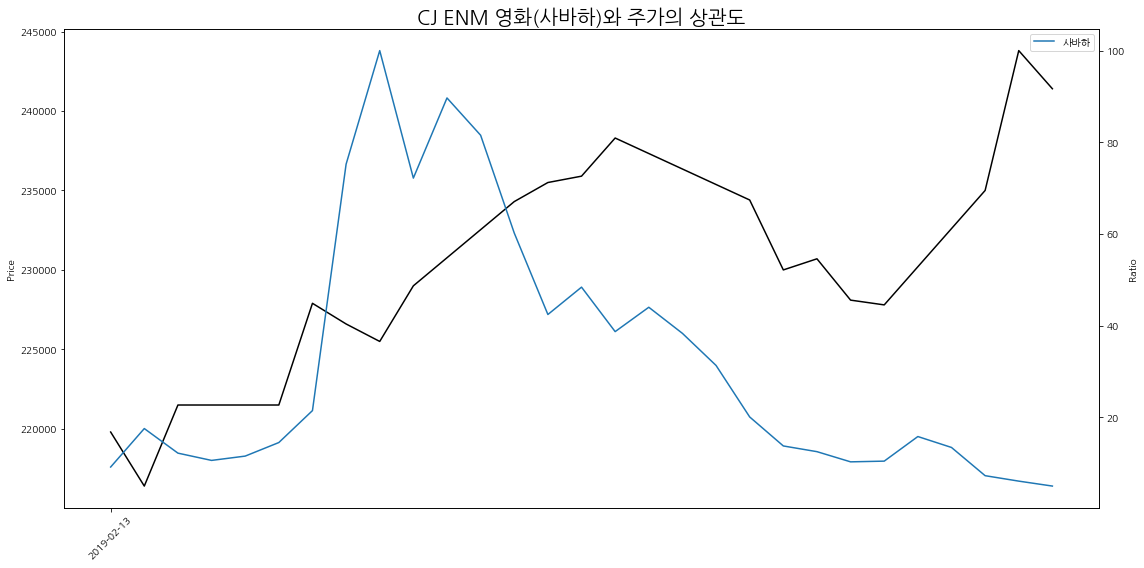

****************************************
              CLOSEP         사바하
count      29.000000   29.000000
mean   230398.275862   32.208351
std      6743.870813   28.098339
min    216400.000000    5.022540
25%    226600.000000   11.558700
50%    230700.000000   17.565650
75%    235375.000000   44.022350
max    243800.000000  100.000000
****************************************
          CLOSEP       사바하
CLOSEP  1.000000  0.082213
사바하     0.082213  1.000000
****************************************
             CLOSEP  사바하_shift
CLOSEP     1.000000   0.574828
사바하_shift  0.574828   1.000000
****************************************


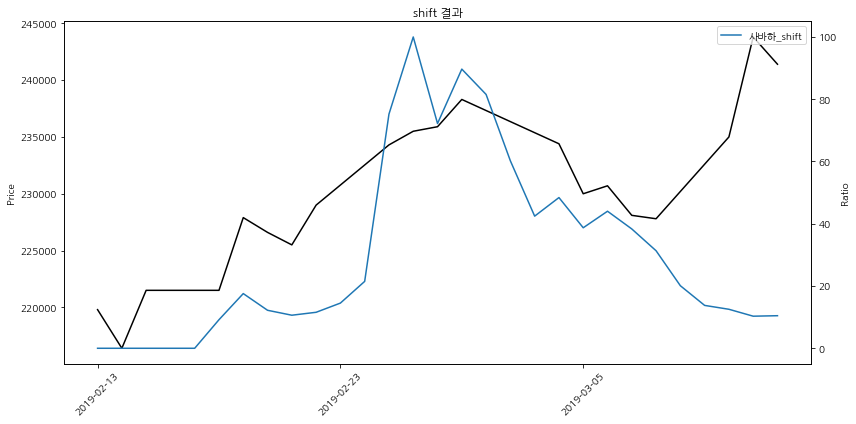

In [ ]:
keywords = [['사바하']]
movie2_df=MyDBLab(keywords, '2019-02-13', '2019-03-13', 'date', 'Stock_data.cj_enm_stock')
pltDBLab(movie2_df, keywords, 30, 'CJ ENM 영화(사바하)와 주가의 상관도')
shiftLab(movie2_df, '사바하', 5)

### 걸캅스

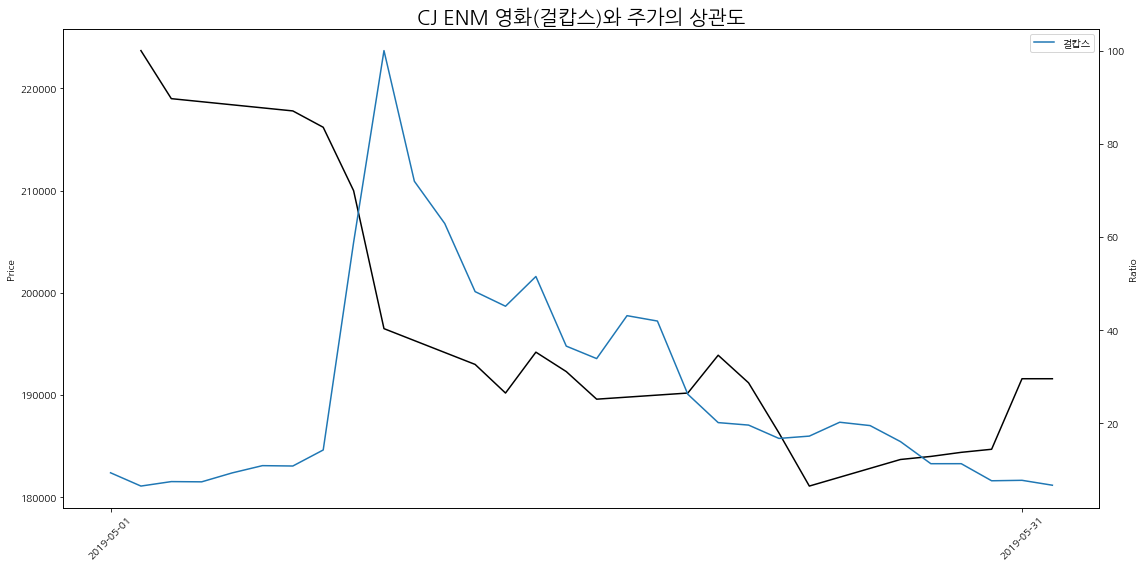

****************************************
              CLOSEP         걸캅스
count      31.000000   32.000000
mean   196596.774194   27.234922
std     13407.411866   22.931466
min    181100.000000    6.552710
25%    187950.000000   10.492725
50%    191600.000000   18.402125
75%    203250.000000   42.254640
max    223700.000000  100.000000
****************************************
          CLOSEP       걸캅스
CLOSEP  1.000000 -0.166062
걸캅스    -0.166062  1.000000
****************************************
             CLOSEP  걸캅스_shift
CLOSEP     1.000000  -0.509191
걸캅스_shift -0.509191   1.000000
****************************************


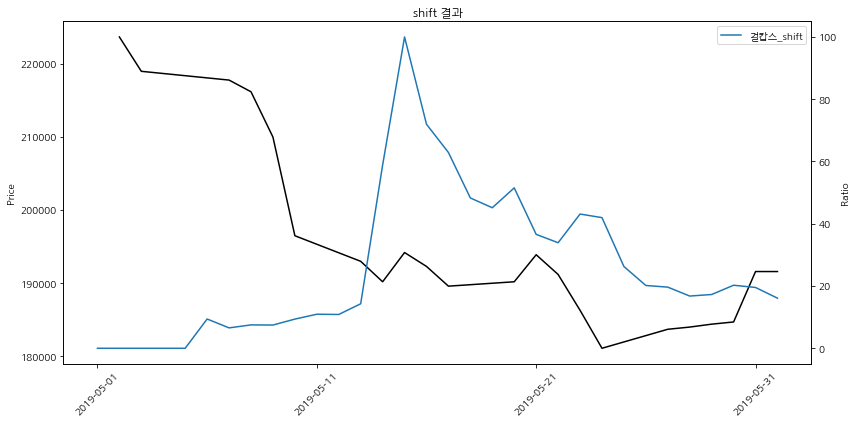

In [ ]:
keywords = [['걸캅스']]
movie3_df=MyDBLab(keywords, '2019-05-01', '2019-06-01', 'date', 'Stock_data.cj_enm_stock')
pltDBLab(movie3_df, keywords, 30, 'CJ ENM 영화(걸캅스)와 주가의 상관도')
shiftLab(movie3_df, '걸캅스', 5)

## 나쁜녀석들

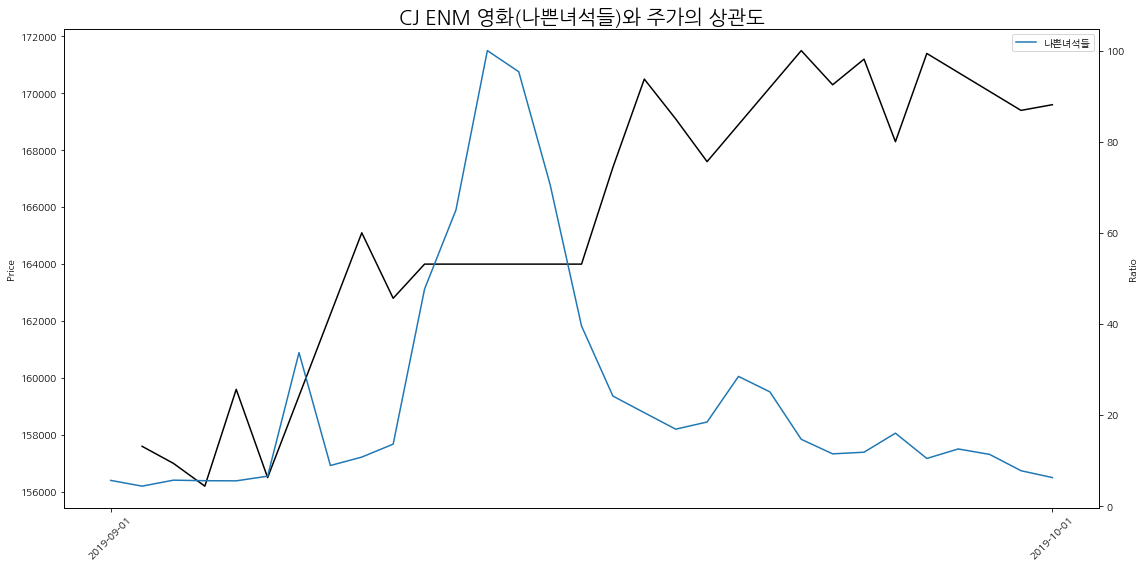

****************************************
              CLOSEP       나쁜녀석들
count      30.000000   31.000000
mean   165553.333333   24.377307
std      4913.688753   25.669939
min    156200.000000    4.429210
25%    163100.000000    8.389605
50%    166250.000000   13.651850
75%    169950.000000   26.815735
max    171500.000000  100.000000
****************************************
          CLOSEP     나쁜녀석들
CLOSEP  1.000000 -0.058985
나쁜녀석들  -0.058985  1.000000
****************************************
               CLOSEP  나쁜녀석들_shift
CLOSEP       1.000000     0.471414
나쁜녀석들_shift  0.471414     1.000000
****************************************


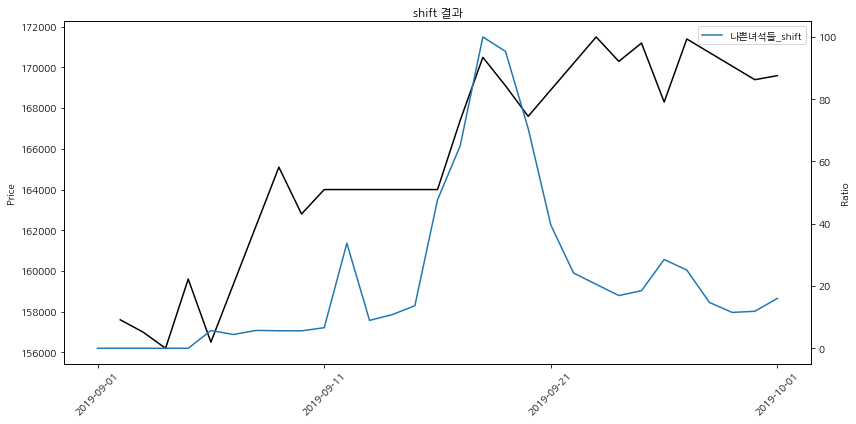

In [ ]:
keywords = [['나쁜녀석들']]
movie4_df=MyDBLab(keywords, '2019-09-01', '2019-10-01', 'date', 'Stock_data.cj_enm_stock')
pltDBLab(movie4_df, keywords, 30, 'CJ ENM 영화(나쁜녀석들)와 주가의 상관도')
shiftLab(movie4_df, '나쁜녀석들', 5)

## 백두산

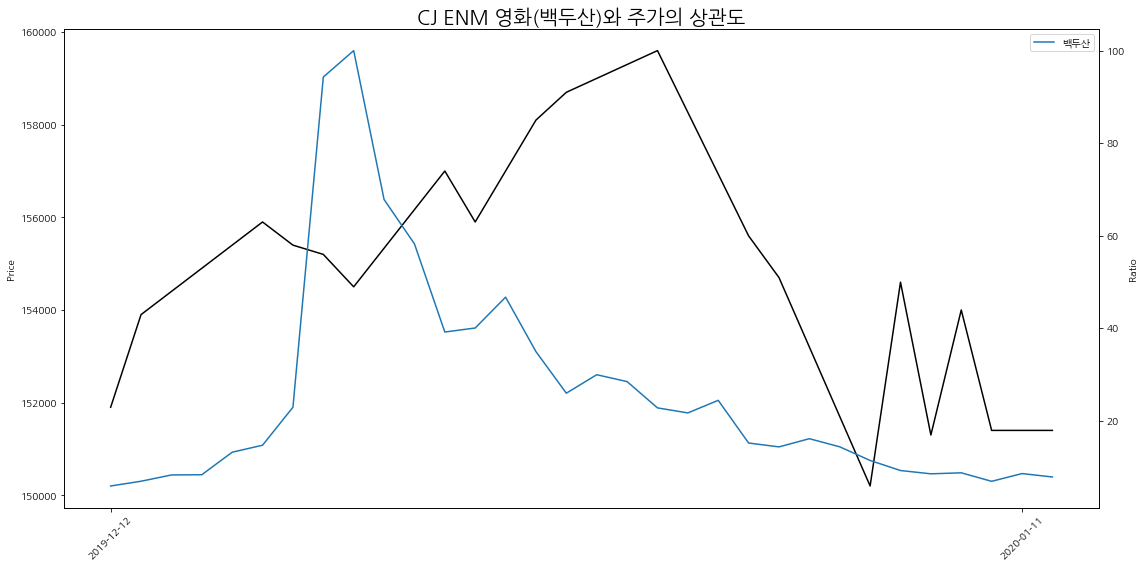

****************************************
              CLOSEP         백두산
count      32.000000   32.000000
mean   155071.875000   26.087526
std      2586.789009   24.198246
min    150200.000000    5.851980
25%    153725.000000    8.659672
50%    155266.666667   15.610620
75%    156950.000000   31.160210
max    159600.000000  100.000000
****************************************
          CLOSEP       백두산
CLOSEP  1.000000  0.318663
백두산     0.318663  1.000000
****************************************
             CLOSEP  백두산_shift
CLOSEP     1.000000   0.534118
백두산_shift  0.534118   1.000000
****************************************


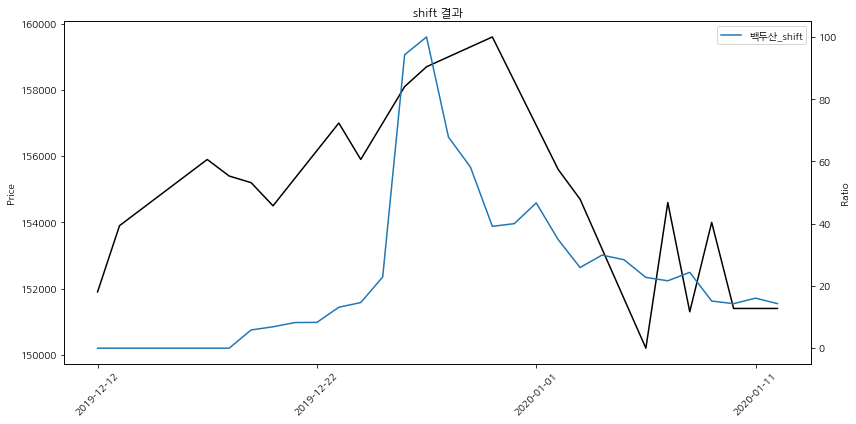

In [ ]:
keywords = [['백두산']]
movie5_df=MyDBLab(keywords, '2019-12-12', '2020-01-12', 'date', 'Stock_data.cj_enm_stock')
pltDBLab(movie5_df, keywords, 30, 'CJ ENM 영화(백두산)와 주가의 상관도')
shiftLab(movie5_df, '백두산', 7)

## 코로나

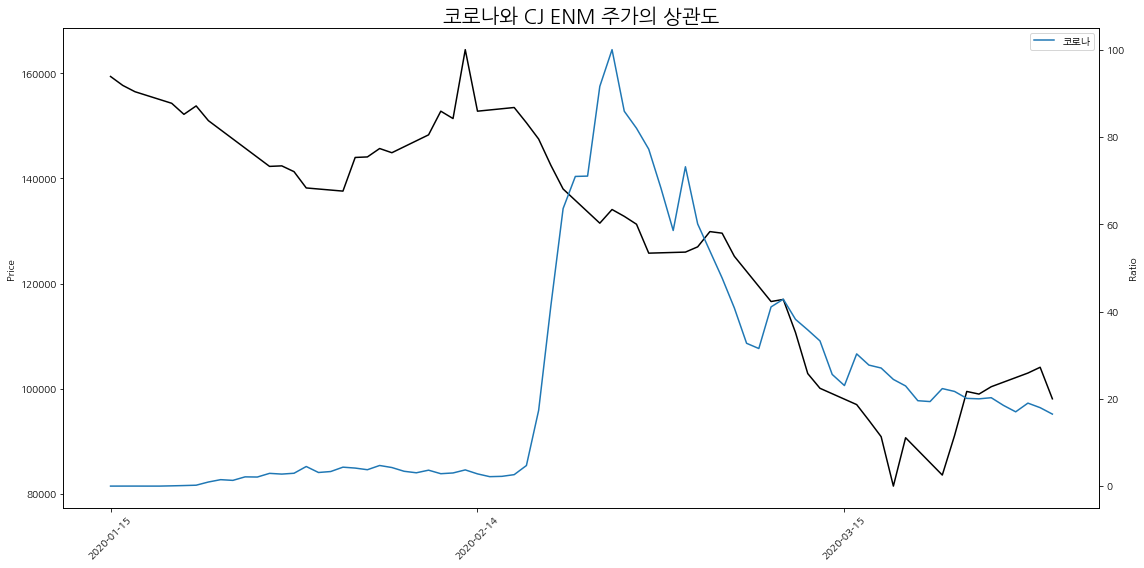

****************************************
              CLOSEP         코로나
count      78.000000   78.000000
mean   128862.820513   23.795473
std     23088.215031   26.309517
min     81500.000000    0.009700
25%    103275.000000    2.935590
50%    134966.666667   18.240720
75%    147515.000000   35.166220
max    164500.000000  100.000000
****************************************
          CLOSEP       코로나
CLOSEP  1.000000 -0.301703
코로나    -0.301703  1.000000
****************************************
             CLOSEP  코로나_shift
CLOSEP     1.000000  -0.714282
코로나_shift -0.714282   1.000000
****************************************


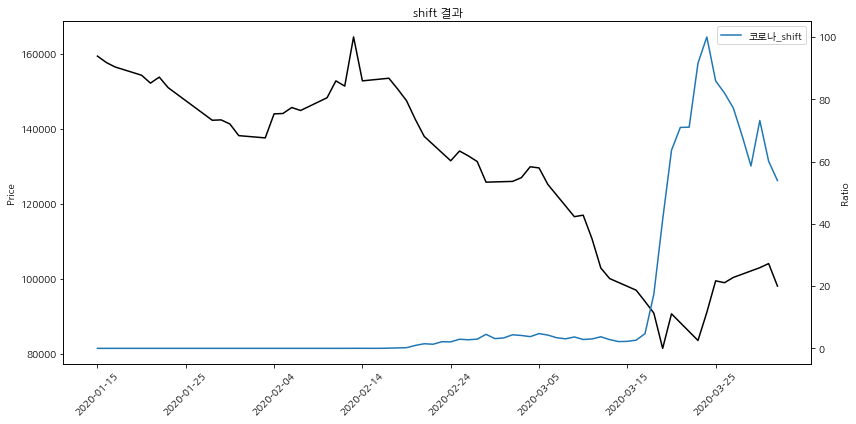

In [ ]:
# 1월 22일 해외 입국자 -> 국내 1번 확진자 
# 2월 18일 신천지 감염 시작, 3월 2일부터 신천지발 감염자 700명 이상

# 2월 18일 - 1월 22일 = 28일 -> 28일 shift

keywords = [['코로나']]
covid_df=MyDBLab(keywords, '2020-01-15', '2020-04-01', 'date', 'Stock_data.cj_enm_stock')
pltDBLab(covid_df, keywords, 30, '코로나와 CJ ENM 주가의 상관도')
shiftLab(covid_df, '코로나', 28)

## 확진자

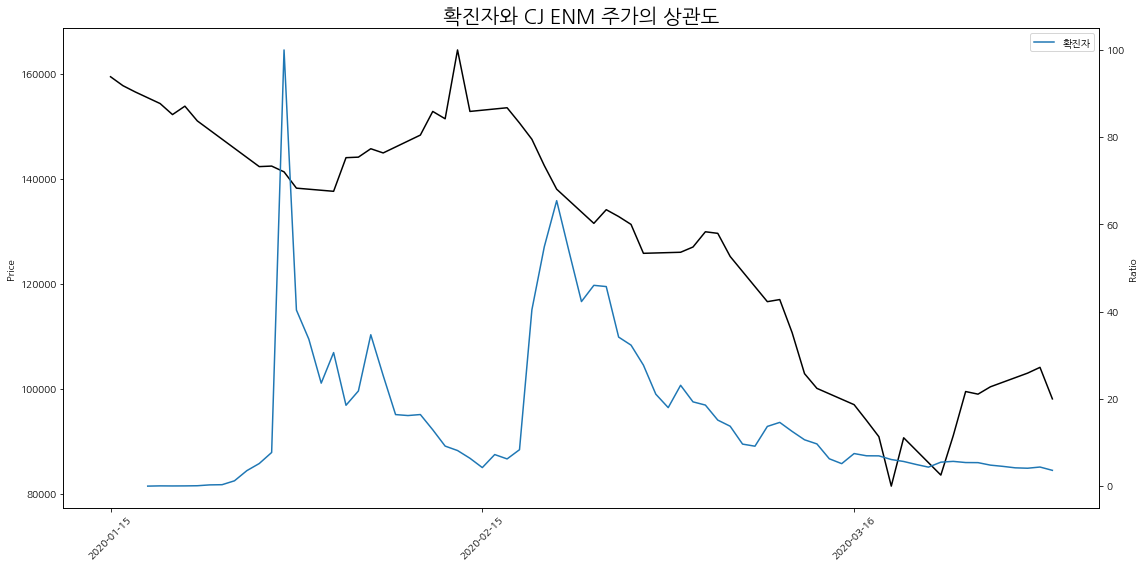

****************************************
              CLOSEP         확진자
count      77.000000   74.000000
mean   128518.181818   16.379360
std     23036.704215   17.848578
min     81500.000000    0.001440
25%    103000.000000    5.158990
50%    134100.000000    9.163395
75%    147500.000000   21.631495
max    164500.000000  100.000000
****************************************
          CLOSEP       확진자
CLOSEP  1.000000  0.229863
확진자     0.229863  1.000000
****************************************
             CLOSEP  확진자_shift
CLOSEP     1.000000  -0.636735
확진자_shift -0.636735   1.000000
****************************************


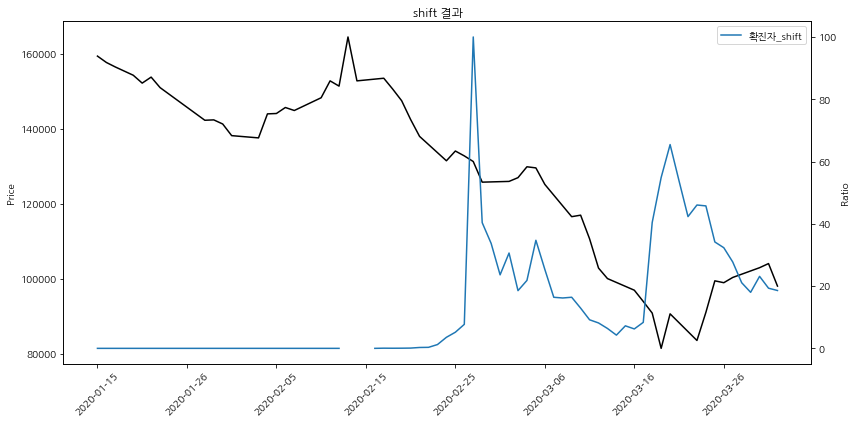

In [ ]:
# 1월 22일 해외 입국자 -> 국내 1번 확진자 
# 2월 18일 신천지 감염 시작, 3월 2일부터 신천지발 감염자 700명 이상

# 2월 18일 - 1월 22일 = 28일 -> 28일 shift

keywords = [['확진자']]
covid_df=MyDBLab(keywords, '2020-01-15', '2020-04-01', 'date', 'Stock_data.cj_enm_stock')
pltDBLab(covid_df, keywords, 30, '확진자와 CJ ENM 주가의 상관도')
shiftLab(covid_df, '확진자', 28)